# Aligned Multi-task Gaussian Processes

This is an illustration of AlignedMTGP on synthetic data

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import gpflow
from gpflow import set_trainable

from amtgp.amtgp import AlignedMTGP
from amtgp.mtgp import MTGP
from amtgp.amtgp_map import AlignedMTGPmap

from data_synthetic import generate_synthetic_data
from utils import remove_data_random, initialize_z, initialize_inducing_points, train, make_ragged_tensor, get_latent_space, smse, snlp, mean_pred, mean_pred2
from plotting import plot_latent, plot_f_post, plot_data_fit

# 1. Generate data
Generate 10 sequences: 2 underlying functions, each warped 5 times with random monotonic warps.
Remove 20% of the data (continuous segment at random location for each sequence).

In [2]:
X, Y, F, G = generate_synthetic_data()
J = len(X)
np.random.seed(2)
data, data_miss, loc = remove_data_random(X, Y, missing_ratio=0.2, cont_segment=True, same_loc=False, return_loc=True)

Plot data and warps

In [3]:
cp1 = sns.color_palette('PuBuGn', n_colors=J)[-J // 2:]
cp2 = sns.color_palette('YlOrBr', n_colors=J)[-J // 2:]
color_palette = cp1 + cp2

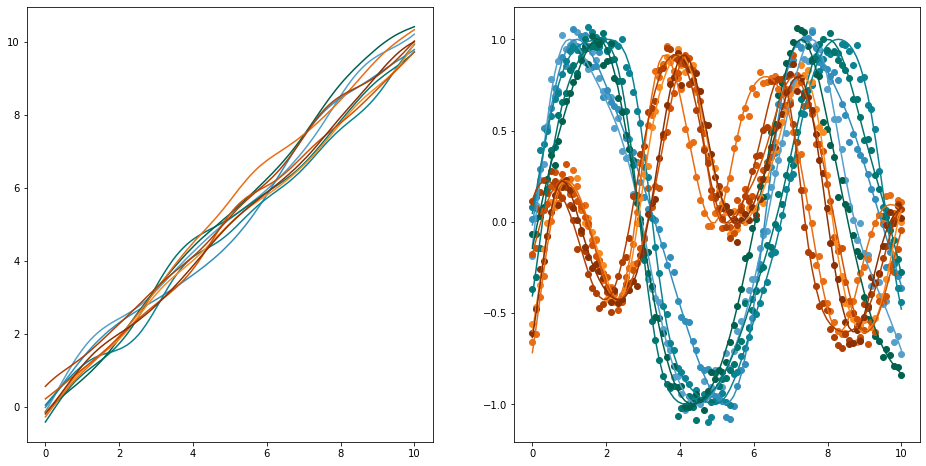

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for i, c in zip(range(len(X)), color_palette):
    ax[0].plot(X[i], G[i], c=c)
    ax[1].plot(X[i], F[i], c=c)
    ax[1].scatter(X[i], Y[i], color=c)
plt.show()

We will further compare 3 different models on this data (MTGP, map-AMTGP and AMTGP). The common parameters for all the models are:

In [5]:
latent_dim = 2
init_var = 0.1

Function to load pretrained models


In [6]:
def load_model(model, output_logdir):
    step_var = tf.Variable(1, dtype=tf.int32, trainable=False)
    ckpt = tf.train.Checkpoint(model=model, step=step_var)
    manager = tf.train.CheckpointManager(ckpt, output_logdir, max_to_keep=5)
    ckpt.restore(manager.latest_checkpoint)
    print('step', step_var.numpy())
    print('elbo:', model.elbo().numpy())

Saved models locations for this data.


In [7]:
save_dir = 'pretrained_models'
mtgp_dir = os.path.join(save_dir, 'mtgp_synthetic_s3_2')
map_amtgp_dir = os.path.join(save_dir,'map_amtgp_synthetic_s3_2')
amtgp_dir = os.path.join(save_dir, 'amtgp_synthetic_s3_2')

# 2. MTGP

This is a regular (non-aligned) MTGP

## 2.1. Build MTGP

In [8]:
num_ind = 250
kernel_x = gpflow.kernels.SquaredExponential(lengthscales=1.,
                                                 active_dims=list(range(latent_dim, latent_dim + 1)))

Z_init = initialize_z(data, PCA_init=True, latent_dim=latent_dim)
# Initialize inducing locations to M random inputs in the dataset (with added Z_pca component)
ind = initialize_inducing_points(data, num_ind=num_ind, Z_init=Z_init)

mtgp = MTGP(kernel_x,
         gpflow.likelihoods.Gaussian(),
         inducing_variable=ind,
         data=data,
         latent_dim=latent_dim,
         Z_data_mean=Z_init)

mtgp.likelihood.variance.assign(init_var)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-2.2521789694259944>

## 2.2. Train MTGP

In [9]:
load_model(model=mtgp, output_logdir=mtgp_dir)

# train_it = 10
# train(mtgp, it=train_it, train_with_natgrad=True, print_step=5)


step 2001
elbo: 764.8875206244519


# 3. MAP-AlignedMTGP

## 3.1 Build MAP-AMTGP

In [10]:
num_ind = 50
kernel_x = gpflow.kernels.SquaredExponential(lengthscales=1.,
                                                 active_dims=list(range(latent_dim, latent_dim + 1)))

warp_kernel = gpflow.kernels.SquaredExponential(lengthscales=.1, variance=0.1)
set_trainable(warp_kernel.variance, False)
set_trainable(warp_kernel.lengthscales, False)
Z_init = initialize_z(data, PCA_init=True, latent_dim=latent_dim)
# Initialize inducing locations to M random inputs in the dataset (with added Z_pca component)
ind = initialize_inducing_points(data, num_ind=num_ind, Z_init=Z_init)

map_amtgp = AlignedMTGPmap(kernel_x,
                   gpflow.likelihoods.Gaussian(),
                   inducing_variable=ind,
                   data=data,
                   latent_dim=latent_dim,
                   Z_data_mean=Z_init,
                   warp_prior_kernel=warp_kernel)

map_amtgp.likelihood.variance.assign(init_var)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-2.2521789694259944>

## 3.2. Train MAP-AMTGP


In [11]:
load_model(model=map_amtgp, output_logdir=map_amtgp_dir)

# train_it = 2000
# train(map_amtgp, it=train_it, train_with_natgrad=True, print_step=20)

step 2001
elbo: 1117.4393354558863


# 4. AlignedMTGP

## Build AMTGP

In [12]:
num_ind = 50

kernel_x = gpflow.kernels.SquaredExponential(lengthscales=1.,
                                             active_dims=list(range(latent_dim, latent_dim + 1)))

warp_kernel = [gpflow.kernels.Matern52(lengthscales=1., variance=0.1) for _ in range(J)]
Z_init = initialize_z(data, PCA_init=True, latent_dim=latent_dim)
# Initialize inducing locations to M random inputs in the dataset (with added Z component)
ind = initialize_inducing_points(data, num_ind=num_ind, Z_init=Z_init)
amtgp = AlignedMTGP(kernel_x,
                    gpflow.likelihoods.Gaussian(),
                    inducing_variable=ind,
                    data=data,
                    latent_dim=latent_dim,
                    Z_data_mean=Z_init,
                    warp_kernel=warp_kernel)

amtgp.likelihood.variance.assign(init_var)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-2.2521789694259944>

## Training

In [13]:
load_model(model=amtgp, output_logdir=amtgp_dir)

# train_it = 1000
#
# train(amtgp,
#       it=train_it,
#       train_with_natgrad=True,
#       is_warp_nat_grad=True,
#       warp_nat_grad_gamma=0.05,
#       print_step=20)

step 1002
elbo: 750.0013685623027


# 5. Model comparison

Compute SMSE ans SNLP


In [14]:
X_miss, Y_miss = data_miss
X_train, Y_train = data

models = [mtgp, map_amtgp, amtgp]
titles = ['MTGP   ', 'MAP-AMTGP', 'AMTGP  ']

In [15]:
Y_test_pred = []
Y_train_pred = []
test_smse = []
train_smse = []
test_snlp = []
train_snlp = []

In [16]:
# MTGP
Y_test_pred.append(mean_pred(mtgp, X_miss))
Y_train_pred.append(mean_pred(mtgp, X_train))

# MAP-AMTGP
Y_test_pred.append(mean_pred(map_amtgp, X_miss))
Y_train_pred.append(mean_pred(map_amtgp, X_train))

# AMTGP
Y_test_pred.append(mean_pred2(amtgp, X_miss))
Y_train_pred.append(mean_pred2(amtgp, X_train))

In [17]:
for i in range(3):
    test_smse.append(smse(Y_miss, Y_test_pred[i]).numpy())
    train_smse.append(smse(Y_train, Y_train_pred[i]).numpy())

    test_snlp.append(snlp(models[i], X_miss, Y_miss))
    train_snlp.append(snlp(models[i], X_train, Y_train))

In [18]:
print('\t\t\t SNLP \t\t\t\t SMSE')
print('\t\t train \t\t test \t\t train \t\t test')
for i in range(3):
    print(titles[i], '\t', np.round(train_snlp[i], 2), '\t', np.round(test_snlp[i], 2),
          '\t', np.round(train_smse[i], 4), '\t', np.round(test_smse[i], 4))

			 SNLP 				 SMSE
		 train 		 test 		 train 		 test
MTGP    	 -1955.74 	 -114.17 	 0.0065 	 0.1897
MAP-AMTGP 	 -2024.48 	 -204.15 	 0.0061 	 0.032
AMTGP   	 -1820.1 	 -264.27 	 0.0074 	 0.0278


# 6. Plots

We will plot everything on higher frequency input for better visibility.

In [19]:
X_high_freq = [np.expand_dims(np.linspace(x[0][0], x[-1][0], num=3 * x.shape[0]), axis=-1) for x in X]
X_high_freq = make_ragged_tensor(X_high_freq)

## 5.1. Plot latent space

In [20]:
Z_mean_mtgp = mtgp.Z_mean.numpy()
Z_var_mtgp = mtgp.Z_var.numpy()

Z_mean_map_amtgp = map_amtgp.Z_mean.numpy()
Z_var_map_amtgp = map_amtgp.Z_var.numpy()

Z_mean_amtgp = amtgp.Z_mean.numpy()
Z_var_amtgp = amtgp.Z_var.numpy()

scale = 1.1

Z_mean = np.concatenate([Z_mean_mtgp, Z_mean_map_amtgp, Z_mean_amtgp], axis=0)

z_min = np.min(Z_mean) * scale
z_max = np.max(Z_mean) * scale

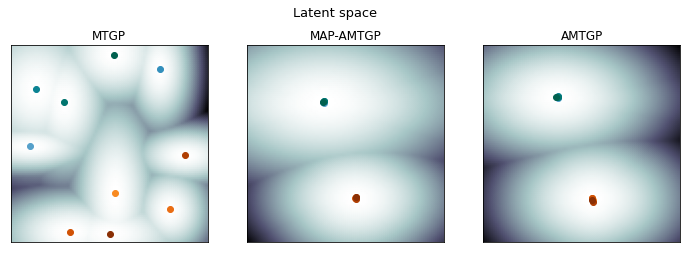

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Latent space', fontsize=13)
plot_latent(Z=Z_mean_mtgp,
            latent_posterior=get_latent_space(Z_mean_mtgp, Z_var_mtgp, z_min=z_min, z_max=z_max, n=100),
            ax=axs[0],
            color_palette=color_palette,
            title='MTGP')

plot_latent(Z=Z_mean_map_amtgp,
            latent_posterior=get_latent_space(Z_mean_map_amtgp, Z_var_map_amtgp, z_min=z_min, z_max=z_max, n=100),
            ax=axs[1],
            color_palette=color_palette,
            title='MAP-AMTGP')

plot_latent(Z=Z_mean_amtgp,
            latent_posterior=get_latent_space(Z_mean_amtgp, Z_var_amtgp, z_min=z_min, z_max=z_max, n=100),
            ax=axs[2], color_palette=color_palette,
            title='AMTGP')

## 5.2 Plot posterior f and data fit

In [22]:
models = [mtgp, map_amtgp, amtgp]
titles = ['MTGP', 'MAP-AMTGP', 'AMTGP']

Sample from the models and compute means and variances

In [23]:
samples = []
sample_means = []
sample_vars = []
G_means = []
for i in range(len(models)):
    sample = models[i].predict_f_samples(X_high_freq, num_samples=100)
    samples.append(sample)
    sample_means.append(tf.map_fn(lambda x: tf.reduce_mean(x, axis=1), sample))
    sample_vars.append(tf.map_fn(lambda x: tf.square(tf.math.reduce_std(x, axis=1)), sample))
    G_means.append(models[i].get_G_mean(X_high_freq))

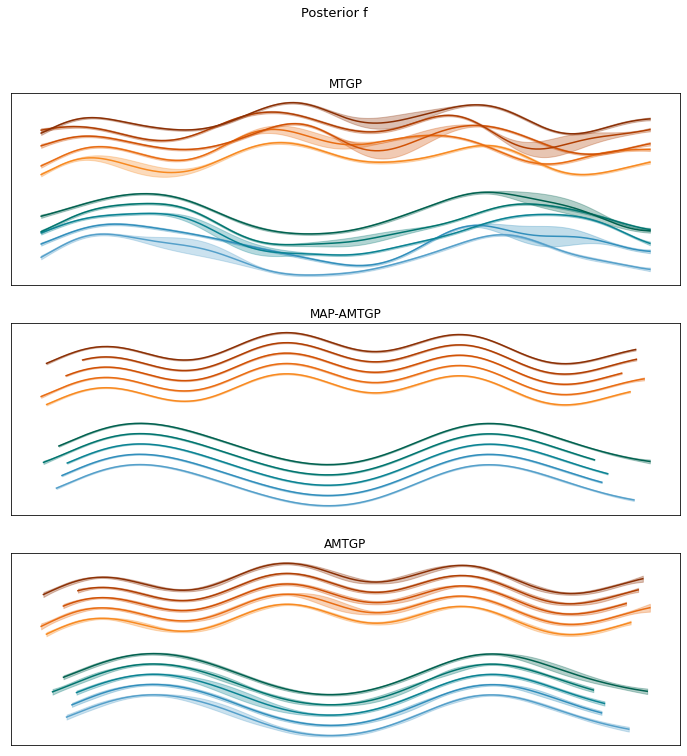

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Posterior f', fontsize=13)

for i in range(len(models)):
    plot_f_post(means=sample_means[i], cov=sample_vars[i], G=G_means[i],
                offset=0.5,
                aaa=[0]*5 + [2]*5,
                ax=axs[i],
                title=titles[i],
                color_palette=color_palette)

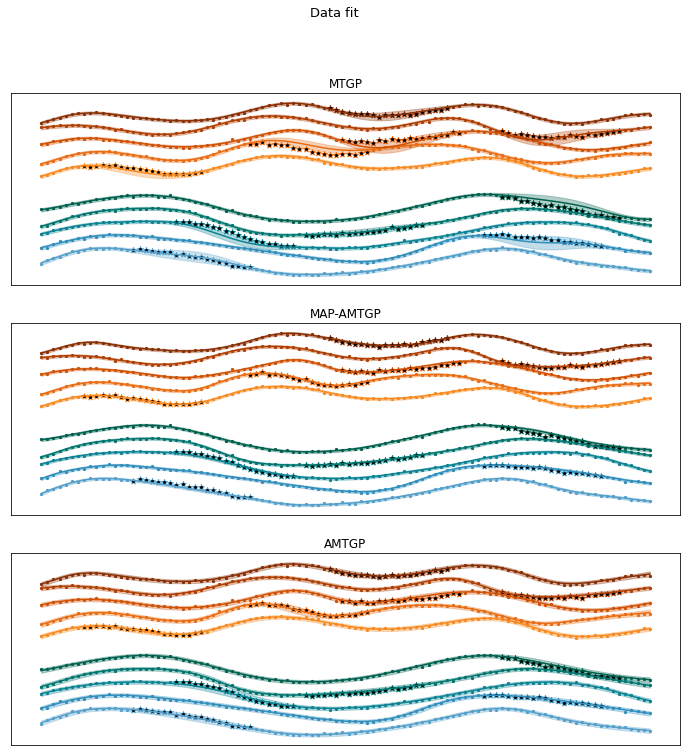

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Data fit', fontsize=13)

for i in range(len(models)):
    plot_data_fit(inputs = data[0],
                  outputs = data[1],
                  inputs_miss = data_miss[0],
                  outputs_miss = data_miss[1],
                  inputs_new = X_high_freq,
                  means=sample_means[i],
                  cov=sample_vars[i],
                  var=models[i].likelihood.variance.numpy(),
                  offset=1,
                  # to_plot=[0, 3, 6, 8],
                  # aaa=[0, 0, 2, 2],
                  aaa=[0]*5 + [2]*5,
                  title=titles[i],
                  ax=axs[i],
                  color_palette=color_palette)